In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score


In [2]:
# Load and preprocess the datamonthly_d
monthly_data = pd.read_csv(r"C:\Users\91970\Downloads\SN_m_tot_V2.0.csv", delimiter=';', header=None)
monthly_data.columns = ["Year", "Month", "FractionalYear", "MonthlyMeanSunspotNumber", "StdDev", "Observations", "Indicator"]
monthly_data = monthly_data[monthly_data["MonthlyMeanSunspotNumber"] != -1]  # Remove missing values

In [3]:
# Create a datetime column
monthly_data['Date'] = pd.to_datetime(monthly_data[['Year', 'Month']].assign(Day=1))
monthly_data = monthly_data[['Date', "MonthlyMeanSunspotNumber"]].rename(columns={'Date': 'ds', "MonthlyMeanSunspotNumber": 'y'})

In [4]:
# Replace zero values and apply log transformation
monthly_data['y'] = monthly_data['y'].replace(0, 1e-6)
monthly_data['y'] = monthly_data['y'].apply(lambda x: np.log(x + 1e-6))
monthly_data = monthly_data[monthly_data['y'] > 0]  # Keep only positive values

In [5]:
# Initialize and fit the Prophet model
monthly_model = Prophet()
monthly_model.fit(monthly_data)

14:34:22 - cmdstanpy - INFO - Chain [1] start processing
14:34:23 - cmdstanpy - INFO - Chain [1] done processing


In [6]:
# Create future dataframes for predictions
future_monthly = monthly_model.make_future_dataframe(periods=9, freq='M')

In [7]:
# Predict for the next 1, 6, and 9 months
forecasts = {
    "1 Month": monthly_model.predict(monthly_model.make_future_dataframe(periods=1, freq='M')),
    "6 Months": monthly_model.predict(monthly_model.make_future_dataframe(periods=6, freq='M')),
    "9 Months": monthly_model.predict(monthly_model.make_future_dataframe(periods=9, freq='M'))
}


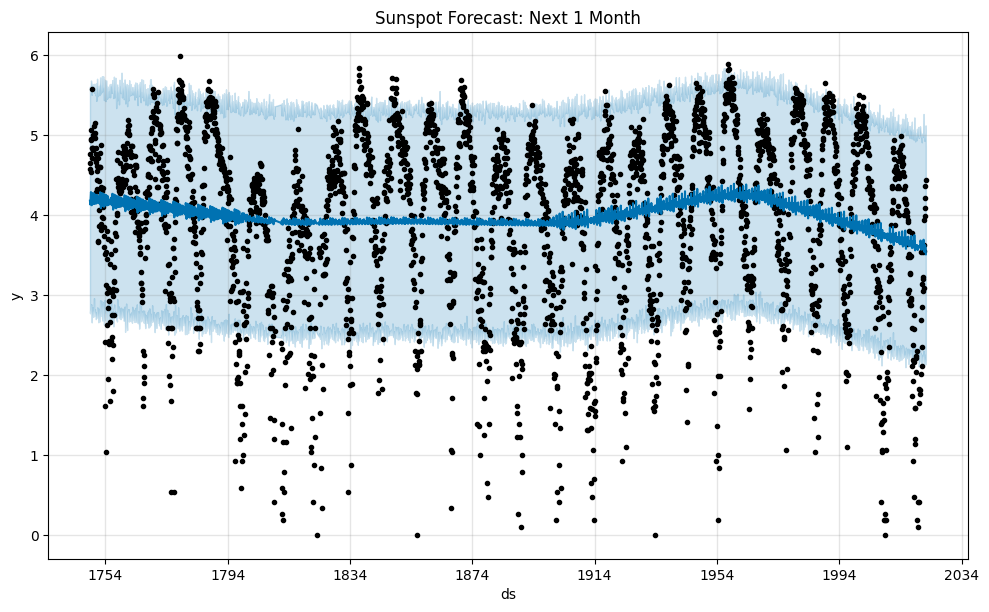

Predicted values for the next 1 Month:
             ds      yhat  yhat_lower  yhat_upper
0    1749-01-01  4.175880    2.772333    5.604575
1    1749-02-01  4.129881    2.817533    5.509275
2    1749-03-01  4.158398    2.803596    5.536895
3    1749-04-01  4.218732    2.765672    5.607833
4    1749-05-01  4.285139    2.863810    5.680886
...         ...       ...         ...         ...
3165 2022-01-01  3.559973    2.143079    4.935114
3166 2022-02-01  3.620803    2.219127    5.038726
3167 2022-03-01  3.580677    2.128940    4.939118
3168 2022-04-01  3.584238    2.161872    5.118885
3169 2022-04-30  3.507254    2.182707    4.856716

[3170 rows x 4 columns]


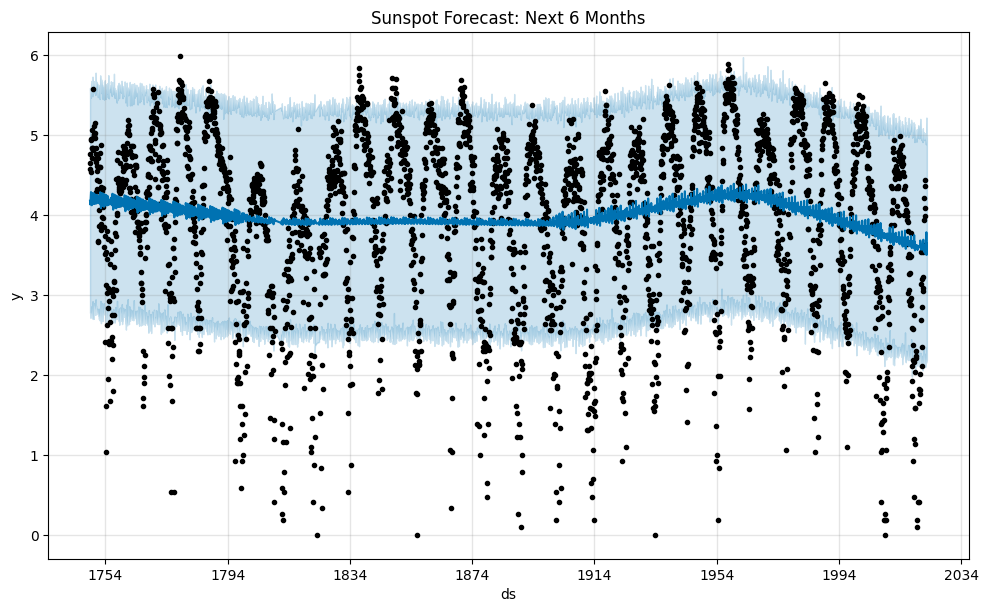

Predicted values for the next 6 Months:
             ds      yhat  yhat_lower  yhat_upper
0    1749-01-01  4.175880    2.774985    5.588635
1    1749-02-01  4.129881    2.783692    5.481532
2    1749-03-01  4.158398    2.712914    5.585204
3    1749-04-01  4.218732    2.764462    5.462462
4    1749-05-01  4.285139    2.785282    5.601990
...         ...       ...         ...         ...
3170 2022-05-31  3.583556    2.222534    4.881961
3171 2022-06-30  3.579150    2.151265    4.943399
3172 2022-07-31  3.782673    2.342796    5.216946
3173 2022-08-31  3.498890    2.173015    4.956652
3174 2022-09-30  3.639754    2.187948    4.997573

[3175 rows x 4 columns]


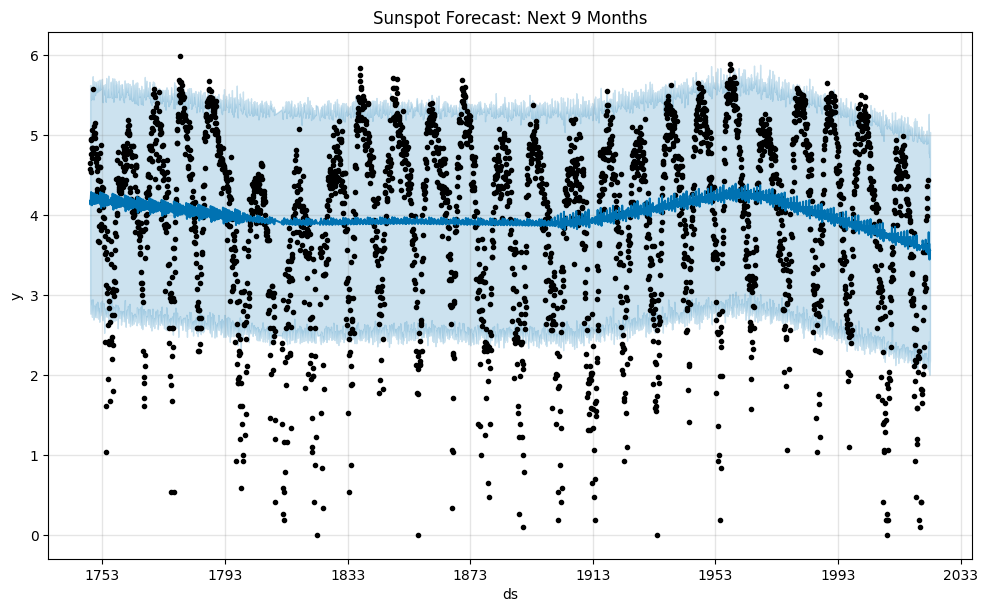

Predicted values for the next 9 Months:
             ds      yhat  yhat_lower  yhat_upper
0    1749-01-01  4.175880    2.929621    5.621470
1    1749-02-01  4.129881    2.804136    5.478117
2    1749-03-01  4.158398    2.761657    5.612001
3    1749-04-01  4.218732    2.771308    5.437362
4    1749-05-01  4.285139    2.886172    5.597717
...         ...       ...         ...         ...
3173 2022-08-31  3.498890    2.043511    4.765991
3174 2022-09-30  3.639754    2.250399    5.000823
3175 2022-10-31  3.441074    2.000960    4.721956
3176 2022-11-30  3.566743    2.144388    4.964276
3177 2022-12-31  3.557673    2.182517    5.036539

[3178 rows x 4 columns]


In [8]:
# Visualize predictions for each forecast
for period, forecast in forecasts.items():
    fig = monthly_model.plot(forecast)
    plt.title(f"Sunspot Forecast: Next {period}")
    plt.show()
    print(f"Predicted values for the next {period}:")
    print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(forecast.shape[0]))


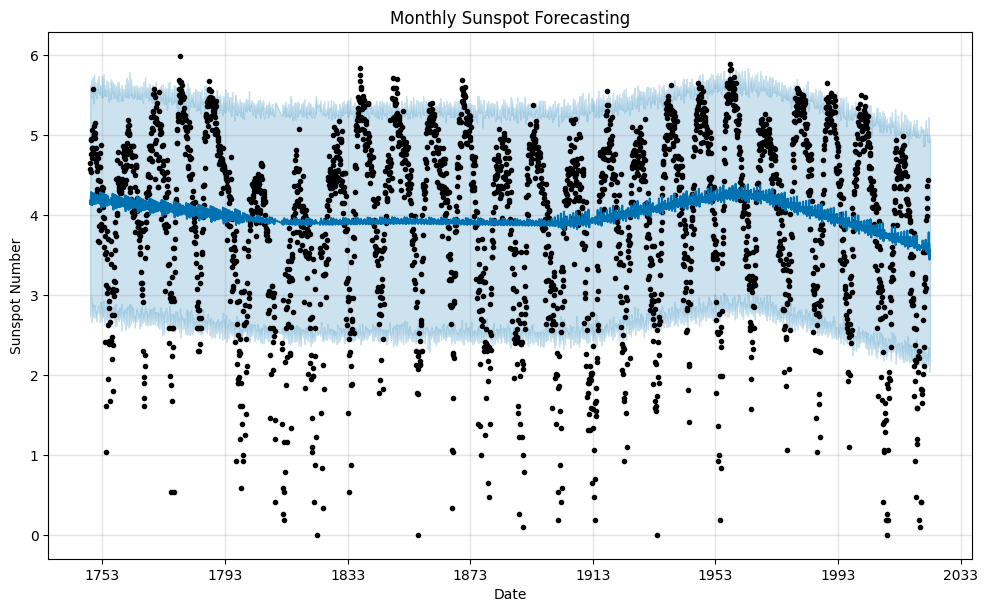

In [9]:
# Final visualization of the monthly forecast
fig_final = monthly_model.plot(monthly_model.predict(future_monthly))
plt.title("Monthly Sunspot Forecasting")
plt.xlabel("Date")
plt.ylabel("Sunspot Number")
plt.show()


In [10]:
# Fit the model with additional seasonality
monthly_model = Prophet(growth='linear', changepoint_prior_scale=0.05)
monthly_model.add_seasonality(name='yearly', period=12, fourier_order=10)

In [11]:
# Fit and predict again
monthly_model.fit(monthly_data)
forecast_monthly = monthly_model.predict(future_monthly)


14:34:35 - cmdstanpy - INFO - Chain [1] start processing
14:34:35 - cmdstanpy - INFO - Chain [1] done processing


In [12]:
# Calculate metrics for the last 9 months
y_true = monthly_data['y'].tail(9)
y_pred = forecast_monthly['yhat'][-9:]

In [13]:
mae = mean_absolute_error(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"Metrics for the last 9 months: MAE: {mae}, MAPE: {mape}, R²: {r2}")

Metrics for the last 9 months: MAE: 0.4728778784064581, MAPE: 0.11664747570952508, R²: -0.8436954010352451
